In [14]:
import asyncio
import json
import time
import pandas as pd
import csv
import io
%matplotlib widget
%matplotlib ipympl


import websockets


# This only works on Python 3.11, not 3.12!
async def stream_trades():
    async with websockets.connect('ws://127.0.0.1:25520/v1/events') as websocket:
        req = {}
        req['msg_type'] = 'STREAM_BULK'
        req['sec_type'] = 'OPTION'
        req['req_type'] = 'TRADE'
        req['add'] = True
        req['id'] = 0
        await websocket.send(req.__str__())
        count = 0
        while True:
            response = await websocket.recv()
            try:
                count += 1
                obj = json.loads(response)
                if obj['header']['type'] == "TRADE" and count % 100 == 0:
                    print('latency: ' + str(get_ms_of_day() - int(obj['trade']['ms_of_day'])))
            except Exception as e:
                print(e)
                print(response)
                exit(1)
            # print(response)


def get_ms_of_day():
    # Add + 1000 to this return statement if you experience negative latencies in the 900s.
    return (int(time.time() * 1000) % 86400000) - 14400000


asyncio.get_event_loop().run_until_complete(stream_trades())

RuntimeError: This event loop is already running

In [3]:
pip install pandas-market-calendars


   -------- ------------------------------- 1/5 [toolz]
   -------- ------------------------------- 1/5 [toolz]
   ---------------- ----------------------- 2/5 [pyluach]
   ------------------------ --------------- 3/5 [exchange-calendars]
   ------------------------ --------------- 3/5 [exchange-calendars]
   ------------------------ --------------- 3/5 [exchange-calendars]
   ------------------------ --------------- 3/5 [exchange-calendars]
   ------------------------ --------------- 3/5 [exchange-calendars]
   ------------------------ --------------- 3/5 [exchange-calendars]
   -------------------------------- ------- 4/5 [pandas-market-calendars]
   -------------------------------- ------- 4/5 [pandas-market-calendars]
   -------------------------------- ------- 4/5 [pandas-market-calendars]
   -------------------------------- ------- 4/5 [pandas-market-calendars]
   ---------------------------------------- 5/5 [pandas-market-calendars]

Note: you may need to restart the kernel to 

In [15]:
import httpx  # pip install httpx
import csv
import io
from datetime import datetime, timedelta

import pandas as pd  # pip install pandas
import pandas_market_calendars as mcal  # pip install pandas-market-calendars

BASE_URL = "http://127.0.0.1:25503/v3"  # all endpoints use this URL base

# --- set params (ThetaData expects YYYYMMDD for start_date/end_date in your code) ---
RAW_PARAMS = {
    "start_date": "2024-11-07",   # will be overwritten day-by-day
    "end_date": "2024-11-07",     # will be overwritten day-by-day
    "symbol": "AAPL",
    "expiration": "2025-01-17",
}

# --- define date range (inclusive) ---
start_date = datetime.strptime("2024-11-07", "%Y-%m-%d")
end_date = datetime.strptime("2025-01-17", "%Y-%m-%d")

# --- NYSE trading days calendar (handles weekends + US market holidays + special closures) ---
nyse = mcal.get_calendar("NYSE")
schedule = nyse.schedule(start_date=start_date.date(), end_date=end_date.date())

# schedule.index is a DatetimeIndex of trading sessions (exchange-localized)
dates_to_run = list(schedule.index.to_pydatetime())

print("Dates to request:", [d.strftime("%Y-%m-%d (%A)") for d in dates_to_run])

all_rows = []
columns = None

for day in dates_to_run:
    day_str = day.strftime("%Y%m%d")

    # IMPORTANT: don't reuse the same dict reference; copy to avoid side effects
    params = RAW_PARAMS.copy()
    params["start_date"] = day_str
    params["end_date"] = day_str

    url = BASE_URL + "/option/history/eod"

    with httpx.stream("GET", url, params=params, timeout=60) as response:
        response.raise_for_status()

        for line in response.iter_lines():
            reader = csv.reader(io.StringIO(line))
            for row in reader:
                if columns is None:
                    columns = row  # header (only once)
                else:
                    all_rows.append(row)


df = pd.DataFrame(all_rows, columns=columns)


for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")

print(df.head())
print("Rows:", len(df), "| Cols:", len(df.columns))


Dates to request: ['2024-11-07 (Thursday)', '2024-11-08 (Friday)', '2024-11-11 (Monday)', '2024-11-12 (Tuesday)', '2024-11-13 (Wednesday)', '2024-11-14 (Thursday)', '2024-11-15 (Friday)', '2024-11-18 (Monday)', '2024-11-19 (Tuesday)', '2024-11-20 (Wednesday)', '2024-11-21 (Thursday)', '2024-11-22 (Friday)', '2024-11-25 (Monday)', '2024-11-26 (Tuesday)', '2024-11-27 (Wednesday)', '2024-11-29 (Friday)', '2024-12-02 (Monday)', '2024-12-03 (Tuesday)', '2024-12-04 (Wednesday)', '2024-12-05 (Thursday)', '2024-12-06 (Friday)', '2024-12-09 (Monday)', '2024-12-10 (Tuesday)', '2024-12-11 (Wednesday)', '2024-12-12 (Thursday)', '2024-12-13 (Friday)', '2024-12-16 (Monday)', '2024-12-17 (Tuesday)', '2024-12-18 (Wednesday)', '2024-12-19 (Thursday)', '2024-12-20 (Friday)', '2024-12-23 (Monday)', '2024-12-24 (Tuesday)', '2024-12-26 (Thursday)', '2024-12-27 (Friday)', '2024-12-30 (Monday)', '2024-12-31 (Tuesday)', '2025-01-02 (Thursday)', '2025-01-03 (Friday)', '2025-01-06 (Monday)', '2025-01-07 (Tuesda

C:\Users\pc\AppData\Local\Temp\ipykernel_35564\2895876079.py:61: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [16]:
df

,symbol,expiration,strike,right,created,last_trade,open,high,low,close,volume,count,bid_size,bid_exchange,bid,bid_condition,ask_size,ask_exchange,ask,ask_condition
0,AAPL,2025-01-17,30.000,CALL,2024-11-07T17:21:28.618,2024-11-07T00:00:00,0.00,0.00,0.00,0.00,0,0,30,76,197.45,50,1,7,199.10,50
1,AAPL,2025-01-17,30.000,PUT,2024-11-07T17:21:28.618,2024-11-07T00:00:00,0.00,0.00,0.00,0.00,0,0,0,76,0.00,50,30,11,0.01,50
2,AAPL,2025-01-17,190.000,CALL,2024-11-07T17:21:28.618,2024-11-07T15:30:28.512,38.10,40.08,37.90,39.95,1361,73,2,60,39.50,50,2,60,40.05,50
3,AAPL,2025-01-17,190.000,PUT,2024-11-07T17:21:28.618,2024-11-07T15:29:49.716,0.58,0.58,0.43,0.46,1095,56,18,69,0.42,50,18,60,0.45,50
4,AAPL,2025-01-17,350.000,PUT,2024-11-07T17:21:28.618,2024-11-07T00:00:00,0.00,0.00,0.00,0.00,0,0,30,76,122.15,50,30,76,122.70,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,AAPL,2025-01-17,5.000,CALL,2025-01-17T17:23:35.49,2025-01-17T00:00:00,0.00,0.00,0.00,0.00,0,0,110,7,223.55,50,110,7,226.70,50
7813,AAPL,2025-01-17,5.000,PUT,2025-01-17T17:23:35.49,2025-01-17T15:20:30.66,0.01,0.01,0.01,0.01,10,1,0,47,0.00,50,4530,11,0.01,50
7814,AAPL,2025-01-17,207.500,PUT,2025-01-17T17:23:35.49,2025-01-17T12:37:11.986,0.01,0.01,0.01,0.01,29,14,0,5,0.00,50,768,76,0.01,50
7815,AAPL,2025-01-17,165.000,CALL,2025-01-17T17:23:35.49,2025-01-17T15:57:06.769,65.24,66.40,63.90,64.67,14,11,110,7,63.30,50,110,7,66.35,50


Only one expiration in df -> plotting smile (surface needs multiple expirations).


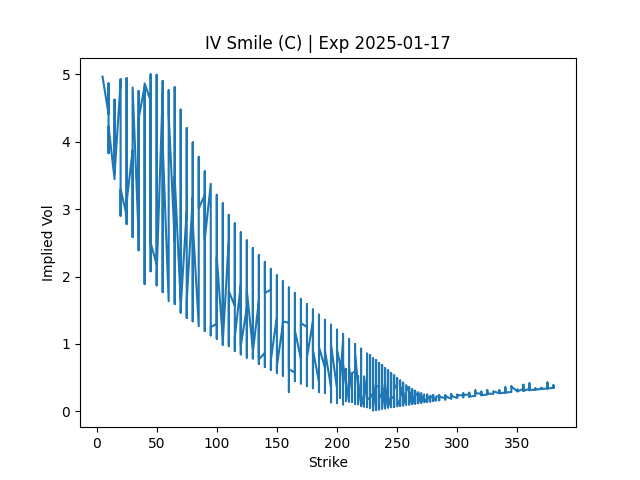

Only one expiration in df -> plotting smile (surface needs multiple expirations).


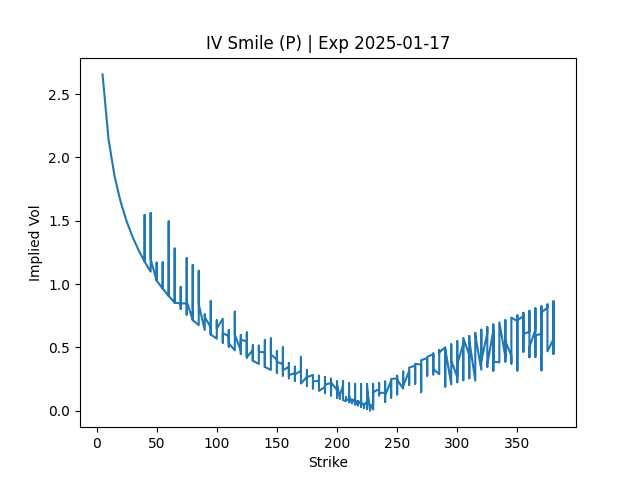

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata

def bs_price(S, K, T, r, q, sigma, right):
    right = right.upper()
    if T <= 0:
        return max(S - K, 0.0) if right == "C" else max(K - S, 0.0)

    sigma = max(float(sigma), 1e-12)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if right == "C":
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


def implied_vol(S, K, T, r, q, price, right):
    if not (np.isfinite(price) and price > 0 and T > 0 and S > 0 and K > 0):
        return np.nan

    discS = S * np.exp(-q * T)
    discK = K * np.exp(-r * T)

    if right == "C":
        lower = max(discS - discK, 0.0)
        upper = discS
    else:
        lower = max(discK - discS, 0.0)
        upper = discK

    if price < lower - 1e-10 or price > upper + 1e-10:
        return np.nan

    f = lambda sig: bs_price(S, K, T, r, q, sig, right) - price
    try:
        return brentq(f, 1e-6, 5.0, maxiter=200)
    except Exception:
        return np.nan


def build_iv_points_from_thetadata_df(
    df: pd.DataFrame,
    valuation_date: str,
    spot: float,
    r: float = 0.03,
    q: float = 0.00,
    use_mid: bool = True,
):
    d = df.copy()

    # expiration in your df looks already like a date, but make it robust:
    d["expiration"] = pd.to_datetime(d["expiration"], errors="coerce")

    # strike numeric
    d["strike"] = pd.to_numeric(d["strike"], errors="coerce")

    # right: "CALL"/"PUT" -> "C"/"P"
    d["right"] = d["right"].astype(str).str.upper().map({"CALL": "C", "PUT": "P"})

    # Price: prefer mid=(bid+ask)/2 if ask exists and is usable; else fall back to close
    # Your screenshot clearly has 'bid'. 'ask' is likely present but cropped; handle both cases.
    d["bid"] = pd.to_numeric(d.get("bid"), errors="coerce")
    if "ask" in d.columns:
        d["ask"] = pd.to_numeric(d["ask"], errors="coerce")
    else:
        d["ask"] = np.nan

    d["close"] = pd.to_numeric(d.get("close"), errors="coerce")

    if use_mid and d["ask"].notna().any():
        d["price"] = (d["bid"] + d["ask"]) / 2.0
        # if bid/ask are zero on deep OTM, this can produce garbage; fallback to close when mid invalid
        d.loc[~np.isfinite(d["price"]) | (d["price"] <= 0), "price"] = d["close"]
    else:
        d["price"] = d["close"]

    # Time to expiry
    val_dt = pd.to_datetime(valuation_date)
    d["T"] = (d["expiration"] - val_dt).dt.days / 365.0

    # Basic filtering to avoid nonsense rows (your df has a lot of zeros)
    d = d[
        (d["T"] > 0)
        & (d["strike"] > 0)
        & (d["price"] > 0)
        & d["right"].isin(["C", "P"])
    ].copy()

    # Optional: remove extremely stale/no-trade prints
    # e.g. drop if volume==0 AND close==0 (already dropped by price>0) so ok.

    # Compute IV
    d["iv"] = d.apply(
        lambda row: implied_vol(spot, row["strike"], row["T"], r, q, row["price"], row["right"]),
        axis=1,
    )

    d = d[np.isfinite(d["iv"])].copy()

    return d[["expiration", "T", "strike", "right", "price", "iv"]]

def plot_smile(iv_points: pd.DataFrame, right: str = "C"):
    sub = iv_points[iv_points["right"] == right].sort_values("strike")
    exp = sub["expiration"].iloc[0]
    plt.figure()
    plt.plot(sub["strike"], sub["iv"])
    plt.xlabel("Strike")
    plt.ylabel("Implied Vol")
    plt.title(f"IV Smile ({right}) | Exp {exp.date()}")
    plt.show()


def plot_surface(iv_points: pd.DataFrame, right: str = "C"):
    sub = iv_points[iv_points["right"] == right].copy()
    n_exp = sub["expiration"].nunique()

    if n_exp < 2:
        print("Only one expiration in df -> plotting smile (surface needs multiple expirations).")
        plot_smile(iv_points, right=right)
        return

    x = sub["T"].to_numpy()
    y = sub["strike"].to_numpy()
    z = sub["iv"].to_numpy()

    T_grid = np.linspace(x.min(), x.max(), 40)
    K_grid = np.linspace(y.min(), y.max(), 60)
    TT, KK = np.meshgrid(T_grid, K_grid)
    ZZ = griddata((x, y), z, (TT, KK), method="linear")

    # 3D surface
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(TT, KK, ZZ, linewidth=0, antialiased=True)
    ax.set_xlabel("Time to Expiry (years)")
    ax.set_ylabel("Strike")
    ax.set_zlabel("Implied Vol")
    ax.set_title(f"Implied Vol Surface ({right})")
    plt.show()

    # Heatmap
    plt.figure()
    plt.imshow(
        ZZ,
        aspect="auto",
        origin="lower",
        extent=[T_grid.min(), T_grid.max(), K_grid.min(), K_grid.max()],
    )
    plt.xlabel("Time to Expiry (years)")
    plt.ylabel("Strike")
    plt.title(f"Implied Vol Surface Heatmap ({right})")
    plt.colorbar(label="Implied Vol")
    plt.show()



valuation_date = "2024-11-07"
spot = 226.50

iv_points = build_iv_points_from_thetadata_df(
    df,
    valuation_date=valuation_date,
    spot=spot,
    r=0.03,
    q=0.00,
    use_mid=True,
)


plot_surface(iv_points, right="C")
plot_surface(iv_points, right="P")
